In [ ]:
# =========================
# 0) Install + imports
# =========================
!pip -q install gdown

import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Device: cuda


In [ ]:
# =========================
# 1) Download + load CSV
# =========================
gdrive_url = "https://drive.google.com/file/d/1Dz81HEGM-id1H8KqB_Z6MeB7NinVniqH/view"

def gdrive_file_id(url: str) -> str:
    m = re.search(r"/d/([a-zA-Z0-9_-]+)", url)
    if not m:
        raise ValueError("Could not parse file id from url")
    return m.group(1)

file_id = gdrive_file_id(gdrive_url)
csv_path = "manipal_weather.csv"

if not os.path.exists(csv_path):
    import gdown
    gdown.download(f"https://drive.google.com/uc?id={file_id}", csv_path, quiet=False)

df = pd.read_csv(csv_path,skiprows=3)
print("Raw shape:", df.shape)
display(df.head())
print("\nColumns:\n", df.columns.tolist())

Downloading...
From: https://drive.google.com/uc?id=1Dz81HEGM-id1H8KqB_Z6MeB7NinVniqH
To: /content/manipal_weather.csv
100%|██████████| 417k/417k [00:00<00:00, 47.6MB/s]

Raw shape: (5480, 13)


,time,temperature_2m_mean (°C),precipitation_sum (mm),shortwave_radiation_sum (MJ/m²),apparent_temperature_mean (°C),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),sunshine_duration (s),wind_direction_10m_dominant (°),pressure_msl_mean (hPa),cloud_cover_mean (%),dew_point_2m_mean (°C),soil_moisture_0_to_7cm_mean (m³/m³)
0,2011-01-04,24.7,0.0,19.69,27.7,17.4,4.09,36798.94,325,1009.7,70,20.4,0.278
1,2011-01-05,25.4,0.0,17.77,28.5,15.9,3.91,36494.80,309,1008.7,85,20.4,0.276
2,2011-01-06,26.2,0.0,19.31,28.8,18.4,4.45,36924.74,319,1008.7,61,19.4,0.273
3,2011-01-07,25.6,0.0,20.26,28.0,15.6,4.52,37417.72,178,1008.6,12,18.6,0.270
4,2011-01-08,25.2,0.0,20.29,28.2,15.1,4.38,37473.21,313,1008.3,29,20.0,0.268



Columns:
 ['time', 'temperature_2m_mean (°C)', 'precipitation_sum (mm)', 'shortwave_radiation_sum (MJ/m²)', 'apparent_temperature_mean (°C)', 'wind_speed_10m_max (km/h)', 'et0_fao_evapotranspiration (mm)', 'sunshine_duration (s)', 'wind_direction_10m_dominant (°)', 'pressure_msl_mean (hPa)', 'cloud_cover_mean (%)', 'dew_point_2m_mean (°C)', 'soil_moisture_0_to_7cm_mean (m³/m³)']


In [ ]:
# =========================
# 2) Date parsing + filter range
# =========================

date_col = "time"

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)

temp_col = "temperature_2m_mean (°C)"
prec_col = "precipitation_sum (mm)"

# Ensure numeric
df[temp_col] = pd.to_numeric(df[temp_col], errors="coerce")
df[prec_col] = pd.to_numeric(df[prec_col], errors="coerce")

df = df.dropna(subset=[temp_col, prec_col]).reset_index(drop=True)



In [ ]:
# -------------------------
# 5) Define forecast window + correct time split
# -------------------------
EVAL_START = pd.Timestamp("2025-01-04")
EVAL_END   = pd.Timestamp("2026-01-04")

# Train = strictly before eval start
df_train_all = df[df[date_col] < EVAL_START].copy().reset_index(drop=True)

# Test period = eval range
df_test_period = df[(df[date_col] >= EVAL_START) & (df[date_col] <= EVAL_END)].copy().reset_index(drop=True)

print("Train (pre-2025) rows:", len(df_train_all), "|",
      df_train_all[date_col].min(), "->", df_train_all[date_col].max())
print("Test (2025-2026) rows:", len(df_test_period), "|",
      df_test_period[date_col].min(), "->", df_test_period[date_col].max())

if len(df_train_all) < 60:
    print("Warning: very little training data before 2025. Results may be weak.")

Train (pre-2025) rows: 5114 | 2011-01-04 00:00:00 -> 2025-01-03 00:00:00
Test (2025-2026) rows: 366 | 2025-01-04 00:00:00 -> 2026-01-04 00:00:00


In [ ]:
# -------------------------
# 7) Feature sets (your definitions)
# -------------------------
# Univariate -> ONLY temperature history
uni_features_temp = [temp_col]
uni_features_prec = [prec_col]

# Multivariate -> ALL numeric features (excluding date)
numeric_cols = [c for c in df.columns if c != date_col and pd.api.types.is_numeric_dtype(df[c])]
multi_features = list(dict.fromkeys(numeric_cols))  # includes temp + other numeric vars


print("Univariate features:", uni_features_temp , uni_features_prec)
print("Multivariate feature count:", len(multi_features))

Univariate features: ['temperature_2m_mean (°C)'] ['precipitation_sum (mm)']
Multivariate feature count: 12


In [ ]:
# -------------------------
# 8) Windowing + scaling
# -------------------------
WINDOW_DAYS = 14
HORIZON = 1

class StandardScalerNP:
    def __init__(self):
        self.mean_ = None
        self.std_ = None
    def fit(self, X):
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.std_[self.std_ == 0] = 1.0
        return self
    def transform(self, X):
        return (X - self.mean_) / self.std_

def make_windows(df_part, feature_cols, target_col, window_days, horizon=1, date_col=None):
    """
    X: (S, T, F)
    y: (S, 1)  next-day temperature
    dates_y: (S,)
    """
    X_all = df_part[feature_cols].to_numpy(np.float32)   # (N, F)
    y_all = df_part[target_col].to_numpy(np.float32)     # (N,)
    d_all = df_part[date_col].to_numpy()

    X_list, y_list, d_list = [], [], []
    max_i = len(df_part) - window_days - horizon + 1
    for i in range(max_i):
        Xw = X_all[i:i+window_days]                      # (T, F)
        y_idx = i + window_days + horizon - 1
        y_next = y_all[y_idx]                            # scalar
        dy = d_all[y_idx]                                # date of target
        X_list.append(Xw)
        y_list.append([y_next])                          # make (1,) so batch is (B,1)
        d_list.append(dy)

    return np.array(X_list), np.array(y_list), np.array(d_list)

def prepare_data_correct_timeline(feature_cols, target_col):
    ntr = len(df_train_all)
    split = int(ntr * 0.8)

    df_tr = df_train_all.iloc[:split].copy().reset_index(drop=True)
    df_va = df_train_all.iloc[split:].copy().reset_index(drop=True)

    scaler = StandardScalerNP().fit(
        df_tr[feature_cols].to_numpy(np.float32)
    )

    def scale_df(dfi):
        dfo = dfi.copy()
        dfo[feature_cols] = scaler.transform(
            dfo[feature_cols].to_numpy(np.float32)
        )
        return dfo

    df_tr_s = scale_df(df_tr)
    df_va_s = scale_df(df_va)

    df_train_all_s = scale_df(df_train_all)
    context = df_train_all_s.tail(WINDOW_DAYS)

    df_test_s = scale_df(df_test_period)
    df_test_with_context = pd.concat(
        [context, df_test_s], axis=0
    ).reset_index(drop=True)

    Xtr, ytr, _ = make_windows(
        df_tr_s, feature_cols, target_col,
        WINDOW_DAYS, HORIZON, date_col
    )
    Xva, yva, _ = make_windows(
        df_va_s, feature_cols, target_col,
        WINDOW_DAYS, HORIZON, date_col
    )
    Xte_all, yte_all, dte_all = make_windows(
        df_test_with_context, feature_cols, target_col,
        WINDOW_DAYS, HORIZON, date_col
    )

    dte_dt = pd.to_datetime(dte_all)
    mask = (dte_dt >= EVAL_START) & (dte_dt <= EVAL_END)

    Xte, yte, dte = Xte_all[mask], yte_all[mask], dte_all[mask]

    feat_idx = {c: i for i, c in enumerate(feature_cols)}
    t_idx = feat_idx[target_col]

    t_mean = scaler.mean_[t_idx]
    t_std  = scaler.std_[t_idx]

    return (Xtr, ytr), (Xva, yva), (Xte, yte, dte), (t_mean, t_std)




In [ ]:
# -------------------------
# 9) Dataset / DataLoader
# -------------------------
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # (S,T,F)
        self.y = torch.from_numpy(y)  # (S,1)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# -------------------------
# 10) Models (single-layer)
# -------------------------
class SeqRegressor(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size=64, output_size=1):
        super().__init__()
        cell_type = cell_type.upper()
        if cell_type == "RNN":
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        elif cell_type == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        elif cell_type == "LSTM":
            self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        else:
            raise ValueError("cell_type must be RNN/GRU/LSTM")

        self.head = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
      #x = (B,T,F)
        out, _ = self.rnn(x)      # (B,T,H)
        last = out[:, -1, :]      # (B,H)
        return self.head(last)    # (B,1)

In [ ]:
# -------------------------
# 11) Train
# -------------------------
def mae_np(y_true, y_pred):
    # both are (N,1)
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse_np(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def train_model(model, train_loader, val_loader, epochs=200, lr=1e-3, patience=20):
    model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()


    best_val = float("inf")
    best_state = None
    bad = 0
    hist = {"loss": [], "val_loss": []}

    for _ in range(epochs):
        # train
        model.train()
        tr_sum = 0.00
        for Xb, yb in train_loader:     #xb = (B,T,F)
            Xb = Xb.to(DEVICE).float()  # yb = (B,1)
            yb = yb.to(DEVICE).float()
            opt.zero_grad()
            pred = model(Xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            tr_sum += loss.item() * Xb.size(0)
        tr_loss = tr_sum / len(train_loader.dataset)

        # val
        model.eval()
        va_sum = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb = Xb.to(DEVICE).float()
                yb = yb.to(DEVICE).float()
                pred = model(Xb)
                loss = loss_fn(pred, yb)
                va_sum += loss.item() * Xb.size(0)
        va_loss = va_sum / len(val_loader.dataset)

        hist["loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)

        # early stopping
        if va_loss < best_val - 1e-6:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, hist

@torch.no_grad()
def predict(model, X, batch=256):
    model.eval()
    preds = []
    for i in range(0, len(X), batch):
        xb = torch.from_numpy(X[i:i+batch]).to(DEVICE).float()
        pb = model(xb).detach().cpu().numpy()
        preds.append(pb)
    return np.vstack(preds)  # (N,1)



In [ ]:
def run_experiment(feature_cols, target_col, cell_type, batch_size=32):
    (Xtr,ytr), (Xva,yva), (Xte,yte,dte), (t_mean,t_std) = \
        prepare_data_correct_timeline(feature_cols, target_col)

    train_loader = DataLoader(
        SeqDataset(Xtr,ytr), batch_size=batch_size, shuffle=True
    )
    val_loader = DataLoader(
        SeqDataset(Xva,yva), batch_size=batch_size, shuffle=False
    )

    model = SeqRegressor(
        cell_type, input_size=Xtr.shape[2], hidden_size=64
    )

    model, hist = train_model(
        model, train_loader, val_loader
    )

    yhat_scaled = predict(model, Xte)

    y_true = yte * t_std + t_mean
    y_pred = yhat_scaled * t_std + t_mean

    return {
        "target": "precipitation" if target_col == prec_col else "temperature",
        "setting": "multivariate" if len(feature_cols) > 1 else "univariate",
        "model": cell_type,
        "MAE": mae_np(y_true, y_pred),
        "RMSE": rmse_np(y_true, y_pred),
        "history": hist,
        "dates": dte,
        "y_true": y_true,
        "y_pred": y_pred
    }



In [ ]:
# -------------------------
# 13) Train
# -------------------------
results = []

targets = [
    ("temperature", temp_col, uni_features_temp),
    ("precipitation", prec_col, uni_features_prec),
]

for target_name, target_col, uni_feats in targets:
    for setting_name, feat_cols in [
        ("univariate", uni_feats),
        ("multivariate", multi_features)
    ]:
        for cell in ["RNN","GRU","LSTM"]:
            print(f"Training: {target_name.upper()} | {setting_name.upper()} + {cell}")
            results.append(run_experiment(feat_cols, target_col, cell))

metrics_df = pd.DataFrame([{
    "Target": r["target"],
    "Setting": r["setting"],
    "Model": r["model"],
    "MAE": r["MAE"],
    "RMSE": r["RMSE"],
} for r in results]).sort_values(["Target","Setting","RMSE"]).reset_index(drop=True)

display(metrics_df)


Training: TEMPERATURE | UNIVARIATE + RNN
Training: TEMPERATURE | UNIVARIATE + GRU
Training: TEMPERATURE | UNIVARIATE + LSTM
Training: TEMPERATURE | MULTIVARIATE + RNN
Training: TEMPERATURE | MULTIVARIATE + GRU
Training: TEMPERATURE | MULTIVARIATE + LSTM
Training: PRECIPITATION | UNIVARIATE + RNN
Training: PRECIPITATION | UNIVARIATE + GRU
Training: PRECIPITATION | UNIVARIATE + LSTM
Training: PRECIPITATION | MULTIVARIATE + RNN
Training: PRECIPITATION | MULTIVARIATE + GRU
Training: PRECIPITATION | MULTIVARIATE + LSTM


,Target,Setting,Model,MAE,RMSE
0,precipitation,multivariate,LSTM,6.724390,14.869642
1,precipitation,multivariate,GRU,6.662166,14.987802
2,precipitation,multivariate,RNN,6.743493,15.076658
3,precipitation,univariate,LSTM,7.218144,15.527975
4,precipitation,univariate,RNN,7.055953,15.609246
5,precipitation,univariate,GRU,7.039910,15.725339
6,temperature,multivariate,GRU,0.397505,0.522089
7,temperature,multivariate,LSTM,0.403307,0.529276
8,temperature,multivariate,RNN,0.404216,0.530809
9,temperature,univariate,GRU,0.404505,0.526849


In [ ]:
# -------------------------
# 11) Pick best overall per target
# -------------------------
best_by_target = {}
for tgt in metrics_df["Target"].unique():
    best_by_target[tgt] = metrics_df[metrics_df["Target"] == tgt].sort_values("RMSE").iloc[0]
    print(f"\nBEST FOR {tgt.upper()}:\n", best_by_target[tgt])

# Grab full result dicts for plotting best per target
def find_result(target, setting, model):
    for r in results:
        if r["target"] == target and r["setting"] == setting and r["model"] == model:
            return r
    return None

best_temp_row = best_by_target["temperature"]
best_prec_row = best_by_target["precipitation"]

best_temp = find_result(best_temp_row["Target"], best_temp_row["Setting"], best_temp_row["Model"])
best_prec = find_result(best_prec_row["Target"], best_prec_row["Setting"], best_prec_row["Model"])



BEST FOR PRECIPITATION:
 Target     precipitation
Setting     multivariate
Model               LSTM
MAE              6.72439
RMSE           14.869642
Name: 0, dtype: object

BEST FOR TEMPERATURE:
 Target      temperature
Setting    multivariate
Model               GRU
MAE            0.397505
RMSE           0.522089
Name: 6, dtype: object


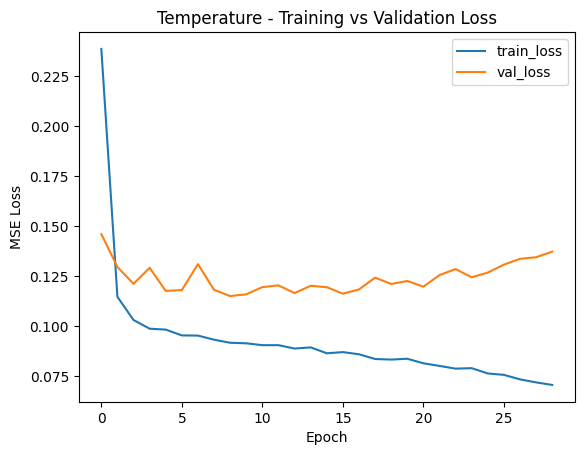

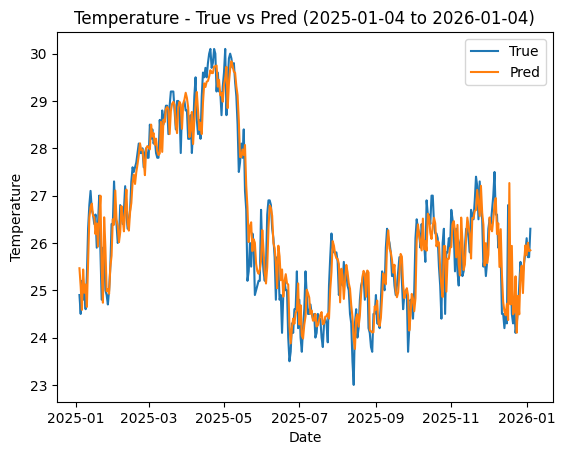

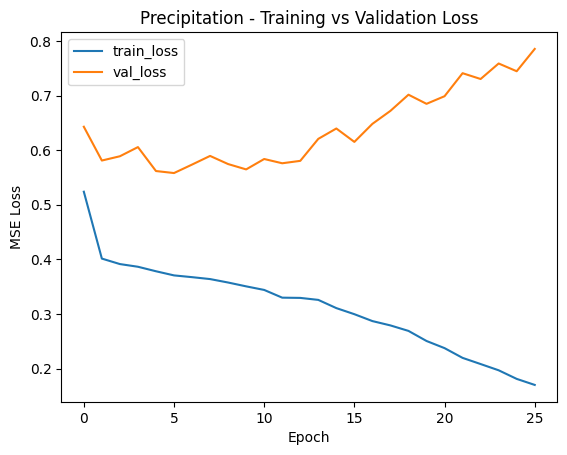

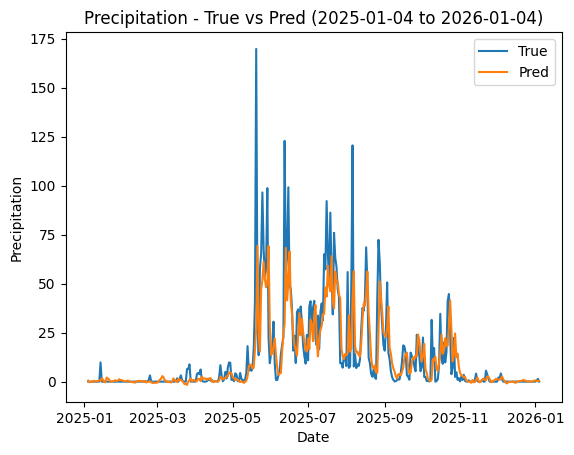

In [ ]:
# -------------------------
# 12) Plots: best model per target
# -------------------------
def plot_best(best_res, title_prefix):
    # Loss curves
    plt.figure()
    plt.plot(best_res["history"]["loss"], label="train_loss")
    plt.plot(best_res["history"]["val_loss"], label="val_loss")
    plt.title(f"{title_prefix} - Training vs Validation Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

    # Prediction vs actual
    dates = pd.to_datetime(best_res["dates"])
    y_true = best_res["y_true"].reshape(-1)
    y_pred = best_res["y_pred"].reshape(-1)

    plt.figure()
    plt.plot(dates, y_true, label="True")
    plt.plot(dates, y_pred, label="Pred")
    plt.title(f"{title_prefix} - True vs Pred (2025-01-04 to 2026-01-04)")
    plt.xlabel("Date"); plt.ylabel(title_prefix)
    plt.legend()
    plt.show()

plot_best(best_temp, "Temperature")
plot_best(best_prec, "Precipitation")